Previsão de Preço de Casas com Apache Spark

Regressão Linear

Neste artigo, usaremos o conjunto de dados da California Housing. Observe, é claro, que esses dados são realmente 'pequenos' e que o uso do Spark nesse contexto pode ser um exagero, porém este notebook é apenas para fins educacionais e deve nos dar uma idéia de como podemos usar o PySpark para construir um modelo de aprendizado de máquina.

Este modelo foi criado com base num estudo do Kaggle

1. Compreendendo o conjunto de dados
O conjunto de dados da California Housing apareceu em um artigo de 1997 intitulado Sparse Spatial Autoregressions, escrito por Pace, R. Kelley e Ronald Barry e publicado na revista Statistics and Probability Letters. Os pesquisadores construíram esse conjunto de dados usando os dados do censo da Califórnia em 1990.

Os dados contêm uma linha por grupo de blocos censitários. Um grupo de blocos é a menor unidade geográfica para a qual o US Census Bureau publica dados de amostra (um grupo de blocos normalmente tem uma população de 600 a 3.000 pessoas). Nesta amostra, um grupo de blocos inclui, em média, 1425,5 indivíduos que vivem em uma área geograficamente compacta.

Esses dados espaciais contêm 20.640 observações sobre os preços da habitação com 9 variáveis econômicas:
  - Longitude: refere-se à distância angular de um local geográfico ao norte ou ao sul do equador da Terra para cada grupo de blocos
  - Latitude: refere-se à distância angular de um local geográfico a leste ou oeste do equador da Terra para cada grupo de blocos
  - Idade média da moradia: é a idade média das pessoas que pertencem a um grupo de quarteirões. Observe que a mediana é o valor que fica no ponto médio de uma distribuição de frequência dos valores observados
  - Total de quartos-de-dormir: é o número total de quartos-de-dormir nas casas por grupo de blocos
  - Total de quartos: é o número total de quartos nas casas por grupo de blocos
  - População: é o número de habitantes de um grupo de blocos
  - Famílias: refere-se a unidades de casas e seus ocupantes por grupo de blocos
  - Renda mediana: é usada para registrar a renda mediana das pessoas que pertencem a um grupo de blocos
  - Valor médio da casa: é a variável dependente e refere-se ao valor médio da casa por grupo de blocos

Além disso, também aprendemos que todos os grupos de blocos têm zero entradas, pois as variáveis independentes e dependentes foram excluídas dos dados.

O valor médio da casa é a variável dependente e será atribuído o papel da variável de destino em nosso modelo de ML.



In [1]:
!pip install pyspark

In [2]:
#Importar as Bibliotecas necessárias
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#Visualização
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# definindo semente aleatória para reprodutibilidade do notebook
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

2. Criando a sessão Spark

In [6]:
spark = SparkSession.builder.master("local[2]").appName("Regressao-Linear-Casas-California").getOrCreate()

In [7]:
spark

In [8]:
sc = spark.sparkContext
sc

<SparkContext master=local[2] appName=Regressao-Linear-Casas-California>

In [9]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

3. Carregar os dados de um arquivo em um Data Frame

In [10]:
CASAS_DATA = '/home/nelson/Documents/Script Python/Predictive_House_Price_Spark/cal_housing.data'

A especificação do esquema ao carregar dados em um DataFrame fornecerá melhor desempenho do que a inferência do esquema.

In [11]:
# define o esquema, correspondente a uma linha no arquivo de dados csv.
schema = StructType([
    StructField("long", FloatType(), nullable=True),
    StructField("lat", FloatType(), nullable=True),
    StructField("medage", FloatType(), nullable=True),
    StructField("totrooms", FloatType(), nullable=True),
    StructField("totbdrms", FloatType(), nullable=True),
    StructField("pop", FloatType(), nullable=True),
    StructField("houshlds", FloatType(), nullable=True),
    StructField("medinc", FloatType(), nullable=True),
    StructField("medhv", FloatType(), nullable=True)]
)


In [12]:
# Carregar dados das casas
casas_df = spark.read.csv(path=CASAS_DATA, schema=schema).cache()

In [13]:
# Inspecionando as 5 primeiras linhas
casas_df.take(5)

[Row(long=-122.2300033569336, lat=37.880001068115234, medage=41.0, totrooms=880.0, totbdrms=129.0, pop=322.0, houshlds=126.0, medinc=8.325200080871582, medhv=452600.0),
 Row(long=-122.22000122070312, lat=37.86000061035156, medage=21.0, totrooms=7099.0, totbdrms=1106.0, pop=2401.0, houshlds=1138.0, medinc=8.301400184631348, medhv=358500.0),
 Row(long=-122.23999786376953, lat=37.849998474121094, medage=52.0, totrooms=1467.0, totbdrms=190.0, pop=496.0, houshlds=177.0, medinc=7.257400035858154, medhv=352100.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1274.0, totbdrms=235.0, pop=558.0, houshlds=219.0, medinc=5.643099784851074, medhv=341300.0),
 Row(long=-122.25, lat=37.849998474121094, medage=52.0, totrooms=1627.0, totbdrms=280.0, pop=565.0, houshlds=259.0, medinc=3.8461999893188477, medhv=342200.0)]

In [14]:
# Mostrar as primeiras cinco linhas
casas_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+--------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|   medhv|
+-------+-----+------+--------+--------+------+--------+------+--------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|452600.0|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|358500.0|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|352100.0|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|341300.0|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|342200.0|
+-------+-----+------+--------+--------+------+--------+------+--------+
only showing top 5 rows



In [15]:
# mostra as colunas do Data Frame
casas_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [16]:
# mostra o esquema do Data Frame
casas_df.printSchema()

root
 |-- long: float (nullable = true)
 |-- lat: float (nullable = true)
 |-- medage: float (nullable = true)
 |-- totrooms: float (nullable = true)
 |-- totbdrms: float (nullable = true)
 |-- pop: float (nullable = true)
 |-- houshlds: float (nullable = true)
 |-- medinc: float (nullable = true)
 |-- medhv: float (nullable = true)



4. Exploração de Dados

In [17]:
# executar uma seleção de amostra
casas_df.select('pop','totbdrms').show(10)

+------+--------+
|   pop|totbdrms|
+------+--------+
| 322.0|   129.0|
|2401.0|  1106.0|
| 496.0|   190.0|
| 558.0|   235.0|
| 565.0|   280.0|
| 413.0|   213.0|
|1094.0|   489.0|
|1157.0|   687.0|
|1206.0|   665.0|
|1551.0|   707.0|
+------+--------+
only showing top 10 rows



4.1 Distribuição da idade média das pessoas que vivem na área:

In [18]:
# Agrupar por housingmedianage e ver a distribuição
resultado_df = casas_df.groupBy("medage").count().sort("medage", ascending=False)

In [19]:
resultado_df.show(10)

+------+-----+
|medage|count|
+------+-----+
|  52.0| 1273|
|  51.0|   48|
|  50.0|  136|
|  49.0|  134|
|  48.0|  177|
|  47.0|  198|
|  46.0|  245|
|  45.0|  294|
|  44.0|  356|
|  43.0|  353|
+------+-----+
only showing top 10 rows



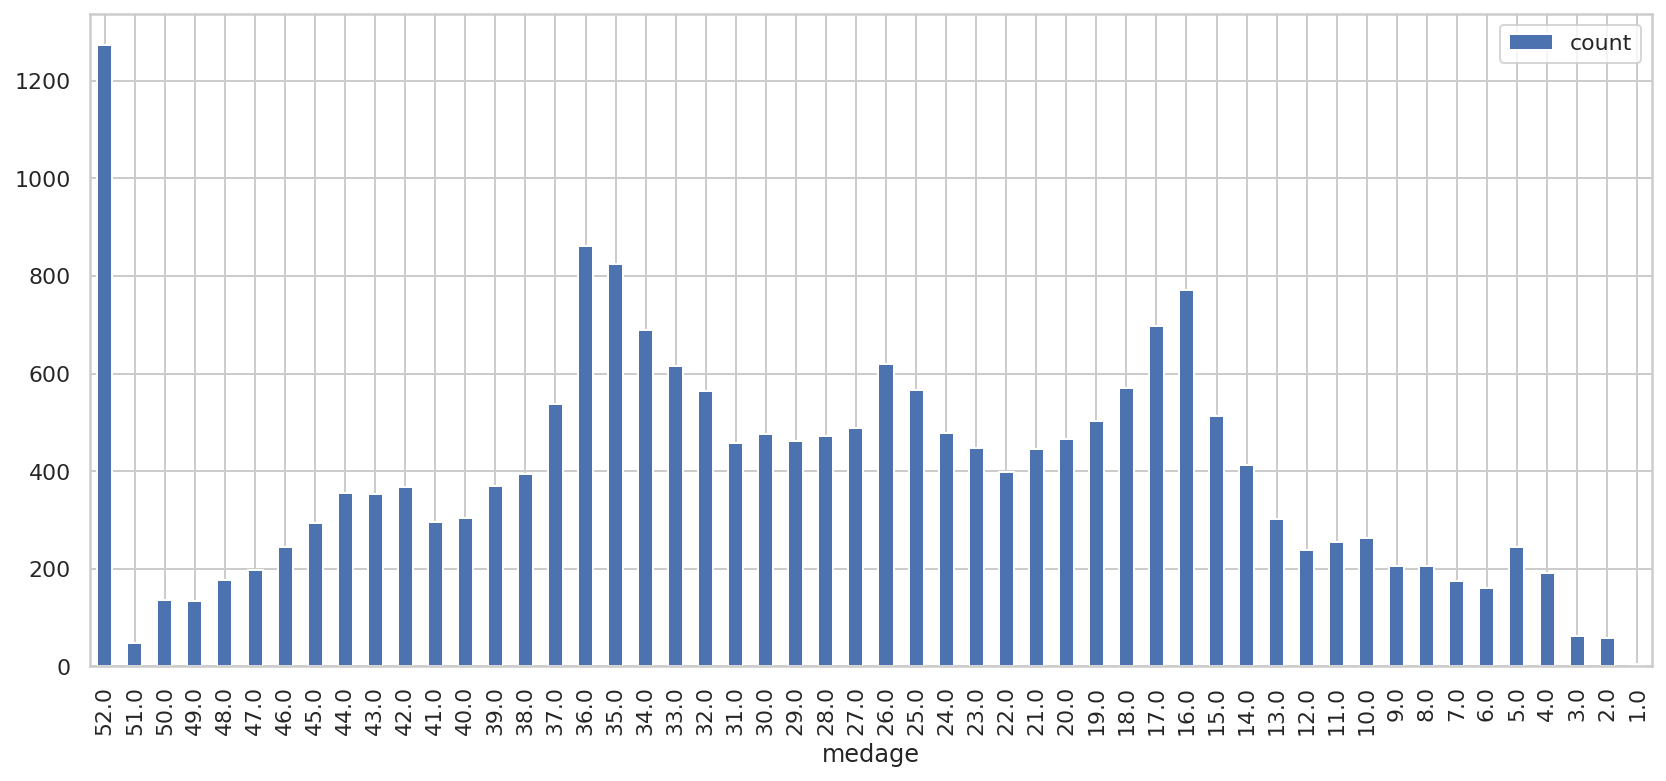

In [20]:
resultado_df.toPandas().plot.bar(x='medage', figsize=(14,6))

A maioria dos residentes está na juventude ou decide morar aqui durante a terceira idade. Alguns dados mostram idade média <10, que parece estar fora do padrão.

4.2 Resumo das estatísticas:
Os DataFrames do Spark incluem algumas funções internas para processamento estatístico. A função describe() executa cálculos estatísticos resumidos em todas as colunas numéricas e os retorna como um DataFrame.

In [21]:
(casas_df.describe().select(
                    "summary",
                    F.round("medage", 4).alias("medage"),
                    F.round("totrooms", 4).alias("totrooms"),
                    F.round("totbdrms", 4).alias("totbdrms"),
                    F.round("pop", 4).alias("pop"),
                    F.round("houshlds", 4).alias("houshlds"),
                    F.round("medinc", 4).alias("medinc"),
                    F.round("medhv", 4).alias("medhv"))
                    .show())

+-------+-------+---------+--------+---------+--------+-------+-----------+
|summary| medage| totrooms|totbdrms|      pop|houshlds| medinc|      medhv|
+-------+-------+---------+--------+---------+--------+-------+-----------+
|  count|20640.0|  20640.0| 20640.0|  20640.0| 20640.0|20640.0|    20640.0|
|   mean|28.6395|2635.7631| 537.898|1425.4767|499.5397| 3.8707|206855.8169|
| stddev|12.5856|2181.6153|421.2479|1132.4621|382.3298| 1.8998|115395.6159|
|    min|    1.0|      2.0|     1.0|      3.0|     1.0| 0.4999|    14999.0|
|    max|   52.0|  39320.0|  6445.0|  35682.0|  6082.0|15.0001|   500001.0|
+-------+-------+---------+--------+---------+--------+-------+-----------+



Veja os valores mínimo e máximo de todos os atributos (numéricos). Vemos que vários atributos têm uma ampla gama de valores: precisamos normalizar este conjunto de dados.

5. Pré-processamento de Dados
Com todas essas informações que coletamos de nossa pequena análise exploratória de dados, sabemos o suficiente para pré-processar nossos dados para alimentá-los com o modelo.
  - não devemos nos preocupar com valores ausentes; todos os valores zero foram excluídos do conjunto de dados.
  - Provavelmente, devemos padronizar nossos dados, pois vimos que a faixa de valores mínimos e máximos é bastante grande.
  - Possivelmente, podemos adicionar alguns atributos adicionais, como um recurso que registra o número de quartos-de-dormir por quartos ou os quartos por família.
  - Nossa variável dependente também é bastante grande; Para facilitar nossa vida, teremos que ajustar um pouco os valores.

5.1 Pré-processamento dos valores alvo
Primeiro, vamos começar com o medianHouseValue, nossa variável dependente. Para facilitar o trabalho com os valores teóricos, expressaremos os valores da casa em unidades de 100.000. Isso significa que um destino como 452600.000000 deve se tornar 4.526:

In [23]:
# Ajustando os valores de `medianHouseValue`
casas_df = casas_df.withColumn("medhv", col("medhv")/100000)

In [24]:
# Exibir as 2 primeiras linhas de 'df'
casas_df.show(2)

+-------+-----+------+--------+--------+------+--------+------+-----+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|
+-------+-----+------+--------+--------+------+--------+------+-----+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|
+-------+-----+------+--------+--------+------+--------+------+-----+
only showing top 2 rows



Podemos ver claramente que os valores foram ajustados corretamente quando analisamos o resultado do método show():

6. Engenharia de recursos
Agora que ajustamos os valores em medianHouseValue, adicionaremos as seguintes colunas ao conjunto de dados:
  - Quartos por domicílio, que se refere ao número de quartos em domicílios por grupo de blocos;
  - População por domicílio, o que basicamente nos dá uma indicação de quantas pessoas vivem em domicílios por grupo de quarteirões; E
  - Quartos-de-dormir por quarto, o que nos dará uma idéia de quantos quartos são quartos por grupo de blocos;
  
Como estamos trabalhando com DataFrames, podemos usar melhor o método select() para selecionar as colunas com as quais trabalharemos, ou seja, totalRooms, households e population. Além disso, temos que indicar que estamos trabalhando com colunas adicionando a função col() ao nosso código. Caso contrário, não poderemos executar operações por elementos, como a divisão que temos em mente para essas três variáveis:

In [25]:
casas_df.columns

['long',
 'lat',
 'medage',
 'totrooms',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'medhv']

In [27]:
# Adicionando novas colunas ao data frame 'df'
casas_df = (casas_df.withColumn("rmsperhh", F.round(col("totrooms")/col("houshlds"), 2))
                       .withColumn("popperhh", F.round(col("pop")/col("houshlds"), 2))
                       .withColumn("bdrmsperrm", F.round(col("totbdrms")/col("totrooms"), 2)))

In [28]:
# Inspecionando o resultado
casas_df.show(5)

+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|   long|  lat|medage|totrooms|totbdrms|   pop|houshlds|medinc|medhv|rmsperhh|popperhh|bdrmsperrm|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
|-122.23|37.88|  41.0|   880.0|   129.0| 322.0|   126.0|8.3252|4.526|    6.98|    2.56|      0.15|
|-122.22|37.86|  21.0|  7099.0|  1106.0|2401.0|  1138.0|8.3014|3.585|    6.24|    2.11|      0.16|
|-122.24|37.85|  52.0|  1467.0|   190.0| 496.0|   177.0|7.2574|3.521|    8.29|     2.8|      0.13|
|-122.25|37.85|  52.0|  1274.0|   235.0| 558.0|   219.0|5.6431|3.413|    5.82|    2.55|      0.18|
|-122.25|37.85|  52.0|  1627.0|   280.0| 565.0|   259.0|3.8462|3.422|    6.28|    2.18|      0.17|
+-------+-----+------+--------+--------+------+--------+------+-----+--------+--------+----------+
only showing top 5 rows



Podemos ver que, na primeira linha, existem cerca de 6,98 quartos por domicílio, os domicílios do grupo de blocos são compostos por cerca de 2,5 pessoas e a quantidade de quartos é bastante baixa com 0,14:

Como não queremos necessariamente padronizar nossos valores-alvo, queremos garantir o isolamento dos valores em nosso conjunto de dados. Observe também que este é o momento de deixar de fora as variáveis que talvez não desejemos considerar em nossa análise. Nesse caso, vamos deixar de fora variáveis como longitude, latitude, HousingMedianAge e totalRooms.

Nesse caso, usaremos o método select() e passaremos os nomes das colunas na ordem que for mais apropriada. Nesse caso, a variável de destino medianHouseValue é colocada em primeiro lugar, para que não seja afetada pela padronização.

In [29]:
# Reordenação e seleção das colunas
casas_df = casas_df.select("medhv", 
                              "totbdrms", 
                              "pop", 
                              "houshlds", 
                              "medinc", 
                              "rmsperhh", 
                              "popperhh", 
                              "bdrmsperrm")

6.1 Extração de recursos
Agora que reorganizamos os dados, estamos prontos para normalizar os dados. Vamos escolher os recursos a serem normalizados.

In [31]:
featureCols = ["totbdrms", "pop", "houshlds", "medinc", "rmsperhh", "popperhh", "bdrmsperrm"]

Use um VectorAssembler para colocar recursos em uma coluna de vetor de recursos:

In [32]:
# coloca recursos em uma coluna de vetor de recursos
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [34]:
assembled_df = assembler.transform(casas_df)

In [35]:
assembled_df.show(10, truncate=False)

+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|medhv|totbdrms|pop   |houshlds|medinc|rmsperhh|popperhh|bdrmsperrm|features                                               |
+-----+--------+------+--------+------+--------+--------+----------+-------------------------------------------------------+
|4.526|129.0   |322.0 |126.0   |8.3252|6.98    |2.56    |0.15      |[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |
|3.585|1106.0  |2401.0|1138.0  |8.3014|6.24    |2.11    |0.16      |[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|
|3.521|190.0   |496.0 |177.0   |7.2574|8.29    |2.8     |0.13      |[190.0,496.0,177.0,7.257400035858154,8.29,2.8,0.13]    |
|3.413|235.0   |558.0 |219.0   |5.6431|5.82    |2.55    |0.18      |[235.0,558.0,219.0,5.643099784851074,5.82,2.55,0.18]   |
|3.422|280.0   |565.0 |259.0   |3.8462|6.28    |2.18    |0.17      |[280.0,565.0,259.0,3.8461999893188477,6.28,2.18,0.17]  |


Todos os recursos se transformaram em um vetor denso.

6.2 Padronização
Em seguida, podemos finalmente escalar os dados usando o StandardScaler. As colunas de entrada são os recursos e a coluna de saída com o redimensionado que será incluído no  será denominada "features_escaladas":

In [37]:
# Inicialize o `standardScaler`
standardScaler = StandardScaler(inputCol="features", outputCol="features_escaladas")

In [38]:
# Ajuste o DataFrame ao redimensionador
escalar_df = standardScaler.fit(assembled_df).transform(assembled_df)

In [39]:
# Inspecionando o resultado
escalar_df.select("features", "features_escaladas").show(10, truncate=False)

+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|features                                               |features_escaladas                                                                                                                    |
+-------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------+
|[129.0,322.0,126.0,8.325200080871582,6.98,2.56,0.15]   |[0.30623297630686513,0.2843362208866199,0.3295584480852433,4.38209543579743,2.8211223886115664,0.24648542140099877,2.5828740130262697]|
|[1106.0,2401.0,1138.0,8.301400184631348,6.24,2.11,0.16]|[2.6255323394991694,2.1201592122632746,2.9764882057222772,4.36956799913841,2.522034914747303,0.20315790592035446,2.755065613894688]   |
|[190.0,496.0,177.0,7.2574000358581

7. Construindo um modelo de aprendizado de máquina com Spark ML

Com todo o pré-processamento concluído, finalmente chegou a hora de começar a construir nosso modelo de regressão linear! Como sempre, primeiro precisamos dividir os dados em conjuntos de treinamento e teste. Felizmente, isso não é problema com o método randomSplit():

In [40]:
# Divida os dados em conjuntos de treino e teste
treino_data, teste_data = escalar_df.randomSplit([.8,.2], seed=rnd_seed)

Passamos em uma lista com dois números que representam o tamanho que queremos que seus conjuntos de treinamento e teste tenham e uma semente, necessária para fins de reprodutibilidade.

Observe que o argumento elasticNetParam corresponde a α ou a interceptação vertical e que o regParam ou o parâmetro de regularização corresponde a λ.

In [41]:
treino_data.columns

['medhv',
 'totbdrms',
 'pop',
 'houshlds',
 'medinc',
 'rmsperhh',
 'popperhh',
 'bdrmsperrm',
 'features',
 'features_escaladas']

Criação de um modelo ElasticNet:
    
ElasticNet é um modelo de regressão linear treinado com L1 e L2 como regularizador. Essa combinação permite aprender um modelo esparso, em que poucos pesos são diferentes de zero como Lasso, mantendo as propriedades de regularização do Ridge. Controlamos a combinação convexa de L1 e L2 usando o parâmetro l1_ratio.    

A rede elástica é útil quando existem vários recursos correlacionados entre si. É provável que o Lasso escolha um deles aleatoriamente, enquanto a rede elástica provavelmente escolha ambos.

Uma vantagem prática da troca entre Lasso e Ridge é que ela permite que a Elastic-Net herde parte da estabilidade de Ridge em rotação.

In [44]:
#Inicializar 'lr'
lr = (LinearRegression(featuresCol='features_escaladas', labelCol="medhv", predictionCol='predmedhv', 
                               maxIter=10, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [45]:
# ajustando os dados ao modelo
linearModel = lr.fit(treino_data)

8. Avaliando o modelo

Com nosso modelo, podemos gerar previsões para nossos dados de teste: use o método transform() para prever os rótulos para nossos dados de teste. Em seguida, podemos usar operações RDD para extrair as previsões e os rótulos verdadeiros do DataFrame.

8.1 Inspecionar os coeficientes do modelo

In [46]:
# Coeficientes para o modelo
linearModel.coefficients

DenseVector([0.0, 0.0, 0.0, 0.526, 0.0, 0.0, 0.0])

In [47]:
featureCols

['totbdrms', 'pop', 'houshlds', 'medinc', 'rmsperhh', 'popperhh', 'bdrmsperrm']

In [49]:
# Interceptação para o modelo
linearModel.intercept

0.989875772139301

In [50]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]

In [51]:
coeff_df

,Feature,Co-efficients
0,Intercept,0.989876
1,totbdrms,0.000000
2,pop,0.000000
3,houshlds,0.000000
4,medinc,0.526024
5,rmsperhh,0.000000
6,popperhh,0.000000
7,bdrmsperrm,0.000000


8.2 Gerando previsões

In [52]:
# geração de previsões
predictions = linearModel.transform(teste_data)

In [53]:
# Extração das previsões e os rótulos corretos "conhecidos"
predandlabels = predictions.select("predmedhv", "medhv")

In [54]:
predandlabels.show()

+------------------+-----+
|         predmedhv|medhv|
+------------------+-----+
|1.5977678077735522|0.269|
|1.3402962575651638|0.275|
|1.7478926681617617|0.283|
|1.5026315463850333|0.325|
|1.5840068859455108|0.344|
|1.4744173855604754|0.379|
|1.5274954532293994|0.388|
|1.3578228236744827|0.394|
|1.6929041021688493|  0.4|
| 2.010874171848204|  0.4|
|1.3656308740705367| 0.41|
|1.4496919091430263|0.421|
| 1.380970081002033|0.425|
|1.3394379493101451| 0.43|
| 1.722973408950696|0.435|
|1.5529131147882111|0.439|
| 1.323489602290725| 0.44|
|1.4030651812673915|0.444|
|1.5111871672959283|0.446|
|1.5996783060975408| 0.45|
+------------------+-----+
only showing top 20 rows



8.3 Inspecionar as métricas
Observar os valores previstos é uma coisa, mas outra coisa melhor é observar algumas métricas para ter uma idéia melhor de quão bom é o seu modelo.

Usando o atributo LinearRegressionModel.summary:
Em seguida, também podemos usar o atributo summary para acessar o rootMeanSquaredError e o r2.

In [55]:
# Obter o RMSE
print("RMSE: {0}".format(linearModel.summary.rootMeanSquaredError))

RMSE: 0.8729980899366503


In [56]:
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

MAE: 0.6714989215155925


In [57]:
# Obter o R2
print("R2: {0}".format(linearModel.summary.r2))

R2: 0.42213332730120356


  - O RMSE mede quanto erro há entre dois conjuntos de dados comparando um valor previsto e um valor observado ou conhecido. Quanto menor um valor RMSE, mais próximos são os valores previstos e observados.
  
  - O R2 ("R ao quadrado") ou o coeficiente de determinação é uma medida que mostra quão próximos os dados estão da linha de regressão ajustada. Essa pontuação sempre estará entre 0 e 100% (neste caso, de 0 a 1), onde 0% indica que o modelo não explica a variabilidade dos dados de resposta em torno de sua média e 100% indica o contrário: explica toda a variabilidade. Isso significa que, em geral, quanto maior o quadrado R, melhor o modelo se ajusta aos nossos dados.

Usando o pacote RegressionEvaluator do pyspark.ml:

In [58]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='rmse')
print("RMSE: {0}".format(evaluator.evaluate(predandlabels)))

RMSE: 0.9033627063798556


In [59]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='mae')
print("MAE: {0}".format(evaluator.evaluate(predandlabels)))

MAE: 0.6888437385796472


In [60]:
evaluator = RegressionEvaluator(predictionCol="predmedhv", labelCol='medhv', metricName='r2')
print("R2: {0}".format(evaluator.evaluate(predandlabels)))

R2: 0.40877519027090536


Usando o pacote RegressionMetrics do pyspark.mllib:

In [62]:
# mllib é antigo, portanto os métodos estão disponíveis no rdd
metrics = RegressionMetrics(predandlabels.rdd)

In [63]:
print("RMSE: {0}".format(metrics.rootMeanSquaredError))

RMSE: 0.9033627063798556


In [64]:
print("MAE: {0}".format(metrics.meanAbsoluteError))

MAE: 0.6888437385796472


In [65]:
print("R2: {0}".format(metrics.r2))

R2: 0.40877519027090536


Definitivamente, existem algumas melhorias necessárias para o nosso modelo! Se quisermos continuar com esse modelo, podemos brincar com os parâmetros que passamos para o seu modelo, as variáveis que incluímos no seu DataFrame original.

In [66]:
# Para o serviço do PySpark
spark.stop()

Dê sua opinião e possíveis melhorias no nosso modelo.
Comente no artigo do blog

Referencias:
https://www.kaggle.com/
https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

Obrigado, e bons estudos